In [18]:
import json
from typing import Tuple, Union
from collections import deque
from matplotlib import pyplot as plt
import pyvis.network as net
import networkx as nx
# graphvis
# https://graphviz.org/download
from graphviz import Digraph
from IPython.display import display, Image, Markdown
EPS = 'eps'


In [19]:
# PART 1


## Part 2 

In [20]:
class State:
    def __init__(self, id: str, is_terminating_state: bool, transitions: dict[str, list[str]]):
        self.id = id
        self.is_terminating_state = is_terminating_state
        self.transitions = transitions

    def have_transition(self, input: str) -> bool:
        return input in self.transitions.keys()



class AutomataMachine:
    def __init__(self, name: str = 'NFA'):
        self.name = name
        self.starting_state: str = None
        self.states = {}

    def init_from_file(self, json_file):
        self.states = self.load_json(json_file)
        return self

    def init_from_dict(self, states: dict[str, bool], starting_state: str, transitions: dict[str, dict[str, list[str]]]):
        self.starting_state = starting_state
        for state, is_terminal in states.items():
            self.add_state(state, is_terminal, transitions[state])

    def load_json(self, json_file) -> dict[str, State]:
        with open(json_file, 'r') as file:
            data = json.load(file)
        # print(data)
        self.starting_state: str = data['startingState']
        data.pop('startingState')

        states = {}
        for key, value in data.items():
            # v can be a list of states or a single state
            transitions = {k: [v] if not isinstance(
                v, list) else v for k, v in value.items() if k != 'isTerminatingState'}

            states[key] = State(
                key, value['isTerminatingState'], transitions)
        return states

    def get_starting_state(self):
        return self.starting_state

    def get_state(self, state):
        return self.states[state]

    def is_terminating_state(self, state):
        return self.states[state].is_terminating_state

    def get_next_state(self, state, input) -> Union[list[str], None]:
        """
        Returns the next state given the current state and input 
        and `None` if the transition is not possible
        """
        if input not in self.states[state].transitions.keys():
            return None
        nxt_state = self.states[state].transitions[input]
        return nxt_state

    def add_state(self, state: str, is_terminating_state: bool, transitions: dict[str, list[str]]):
        self.states[state] = State(state, is_terminating_state, transitions)

    def add_transition(self, state: str, input: str, next_state: str):
        if state not in self.states.keys():
            self.add_state(state, False, {})
        if input not in self.states[state].transitions.keys():
            self.states[state].transitions[input] = []

        self.states[state].transitions[input].append(next_state)

    def save_to_json(self, file):
        with open(file, 'w') as f:
            data = {'startingState': self.starting_state}
            for k, v in self.states.items():
                data[k] = {'isTerminatingState': v.is_terminating_state}
                for kk, vv in v.transitions.items():
                    data[k][kk] = vv[0] if len(vv) == 1 else vv

                data[k] = dict(sorted(data[k].items(),))

            json.dump(data, f, indent=4)

    def draw(self):
        G = nx.MultiDiGraph()
        for state in self.states.values():
            # https://stackoverflow.com/questions/74082881/adding-icon-for-node-shape-using-networkx-and-pyvis-python
            G.add_node(
                state.id, color='gray' if not state.id == self.starting_state else 'orange', shape='diamond' if state.is_terminating_state else 'circle', size=10, font={'size': 8}
            )

            # merge common edges like if 2 edges like (s1,s2,"a") and (s1,s2,"b") are present, merge them to (s1,s2,"a,b")
            merged_edges = {}
            for k, v in state.transitions.items():
                for dest_state in v:
                    edge = (state.id, dest_state, k)
                    if edge[:2] in merged_edges.keys():
                        merged_edges[edge[:2]].append(edge[2])
                    else:
                        merged_edges[edge[:2]] = [edge[2]]

            # finally add the merged edges to the graph
            for k, v in merged_edges.items():
                G.add_edge(k[0], k[1], label=','.join(
                    v), color='gray' if k[1] != EPS else 'red')

        nt = net.Network(notebook=True, cdn_resources='remote', directed=True)
        nt.show_buttons(filter_=['physics'])
        nt.set_edge_smooth('dynamic')
        nt.from_nx(G)
        nt.repulsion(spring_strength=0.02)
        nt.toggle_physics(True)
        nt.show(f'./out_imgs/{self.name}_FSM.html')

        # draw a graphviz graph

        dot = Digraph()
        dot.attr(rankdir='LR')  
        # Set global node attributes.
        dot.attr('node',  color='darkgrey', width='1.2', height='1.2', fixedsize='true')
        # Create an invisible node for pointing to starting states.
        dot.node('start', shape='none', label='', width='0', height='0')

        for state in self.states.values():
            # Determine node shape based on whether it is a terminating state.
            node_shape = 'doublecircle' if state.is_terminating_state else 'circle'
            dot.node(state.id, label=state.id, shape=node_shape)
            # If the state is a starting state, add an invisible edge from the start node to this state.
            if state.id == self.starting_state:
                dot.edge('start', state.id, style='invisible')

            for k, v in state.transitions.items():
                for dest_state in v:
                    dot.edge(state.id, dest_state, label=k)

        dot.render(f'out_imgs/{self.name}_FSM', format='png', cleanup=True)
        return Image(f'out_imgs/{self.name}_FSM.png')
        

        


## NFA TO DFA


In [21]:

class dfa_generator:

    def __init__(self, json_file):
        self.nfa_sm = AutomataMachine().init_from_file(json_file)

    def get_states_group_id(self, states: set[str]):
        """
        if a group contains S0, S3 and S4, the id will be S0_S3_S4
        """
        l = list(states)
        l.sort()
        return '_'.join(l)

    def get_closure(self, state: State) -> Tuple[set[str], set[str], bool]:
        """
        Returns the epsilon closure of a state
        2 sets are returned, one for the states and the other for the combined Transitions
        """
        ret_states = set()
        ret_transitions = set()
        q = deque()
        q.append(state)
        is_terminating = False
        while q:
            curr_state = q.popleft()
            ret_states.add(curr_state.id)
            is_terminating = is_terminating or curr_state.is_terminating_state
            # the transitions of the group is the union of all transitions from each state
            ret_transitions = ret_transitions.union(
                set(curr_state.transitions.keys()))

            if EPS in curr_state.transitions.keys():
                for s in curr_state.transitions[EPS]:
                    if s not in ret_states:
                        q.append(self.nfa_sm.get_state(s))

        return ret_states, ret_transitions, is_terminating

    def convert_to_dfa(self):
        """
        Converts an NFA to a DFA
        """
        start_state = self.nfa_sm.get_starting_state()
        start_closure_states, start_closure_T, is_terminal = self.get_closure(
            self.nfa_sm.get_state(start_state))

        states: dict[str, bool] = {}
        # {state: {input: [next_states]}}
        transitions: dict[str, dict[str, list[str]]] = {}
        q = deque()
        q.append((start_closure_states, start_closure_T, is_terminal))

        while q:
            curr_group_states, curr_group_Ts, is_terminal = q.popleft()
            curr_id = self.get_states_group_id(curr_group_states)
            states[curr_id] = is_terminal
            transitions[curr_id] = {}
            for t in curr_group_Ts:
                if t == EPS:
                    continue
                next_group_states = set()
                next_group_Ts = set()
                next_is_terminal = False

                for state in curr_group_states:
                    s = self.nfa_sm.get_state(state)
                    if s.have_transition(t):
                        # reachable from the current group
                        next_states = s.transitions[t]
                        for ns in next_states:
                            se, te, it = self.get_closure(
                                self.nfa_sm.get_state(ns))
                            next_group_states = next_group_states.union(se)
                            next_group_Ts = next_group_Ts.union(te)
                            next_is_terminal = next_is_terminal or it

                transitions[curr_id][t] = [
                    self.get_states_group_id(next_group_states)]

                if self.get_states_group_id(next_group_states) not in states.keys():
                    q.append((next_group_states, next_group_Ts, next_is_terminal))

        new_dfa = AutomataMachine(name='DFA')
        new_dfa.init_from_dict(states, self.get_states_group_id(
            start_closure_states), transitions)
        return new_dfa

## DFA MINIMIZATION

In [22]:
class DFA_Minimizer:

    def __init__(self, dfa: AutomataMachine):
        self.dfa = dfa
        # we begin by splitting the states into 2 groups, the terminating states and the non-terminating states
        self.list_of_groups: list[set] = [
            {state for state in dfa.states.keys(
            ) if not dfa.is_terminating_state(state)},
            {state for state in dfa.states.keys() if dfa.is_terminating_state(state)}
        ]

    def get_group(self, state: str, list_of_groups: list[set] = None) -> int:
        # if not a local list of groups then use the global one
        if not list_of_groups:
            list_of_groups = self.list_of_groups

        for i, g in enumerate(list_of_groups):
            if state in g:
                return i

        return -1

    def minimize(self):
        # we will keep merging the groups until no more merges can be done
        while True:
            new_groups = []
            for group in self.list_of_groups:
                # if the group has only 1 element, we can't split it any further
                if len(group) == 1:
                    new_groups.append(group)
                    continue

                # we will split the group into subgroups
                subgroups = {}
                for state in group:
                    # get the transitions of the state
                    transitions = self.dfa.states[state].transitions

                    state_transitions_to_go_groups = tuple(
                        sorted([(k, self.get_group(v[0])) for k, v in transitions.items()]))  # this is like (a, 0), (b, 1) etc (input, group_id)
                    if state_transitions_to_go_groups not in subgroups.keys():
                        subgroups[state_transitions_to_go_groups] = set()

                    subgroups[state_transitions_to_go_groups].add(state)

                # add the subgroups to the new groups
                new_groups.extend(subgroups.values())

            # if the new groups are the same as the old groups, we can't split anymore
            if new_groups == self.list_of_groups:
                break
            self.list_of_groups = new_groups

    def reconstruct_dfa(self) -> AutomataMachine:
        # create a new dfa with the new groups
        # get copy of the old dfa
        old_states = self.dfa.states.copy()
        old_starting_state = self.dfa.get_starting_state()
        new_starting_state = None
        new_dfa = AutomataMachine(name='Minimized_DFA')
        for i, group in enumerate(self.list_of_groups):
            # we take the first node as a represintive for the group
            # make it take all the transitions of all the states in the group
            # mark as starting state if the old starting state is in the group
            is_starting = old_starting_state in group
            if is_starting:
                new_starting_state = str(i)
            new_transitions = {}
            is_terminal = False
            for state in group:
                s = old_states[state]
                is_terminal = is_terminal or s.is_terminating_state
                for k, v in s.transitions.items():
                    # transitions should be one-to-one as we have a dfa here
                    new_transitions[k] = [str(self.get_group(v[0]))]

            # add the new state to the new dfa
            new_dfa.add_state(str(i), is_terminal, new_transitions)
        new_dfa.starting_state = new_starting_state

        return new_dfa


./out_imgs/NFA_FSM.html


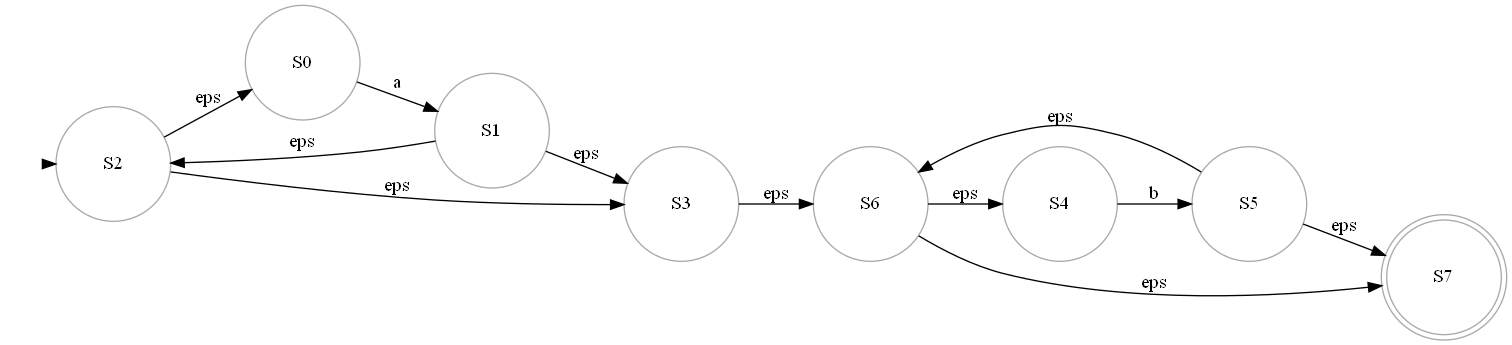

S0_S2_S3_S4_S6_S7 -> True -> {'b': ['S4_S5_S6_S7'], 'a': ['S0_S1_S2_S3_S4_S6_S7']}
S4_S5_S6_S7 -> True -> {'b': ['S4_S5_S6_S7']}
S0_S1_S2_S3_S4_S6_S7 -> True -> {'b': ['S4_S5_S6_S7'], 'a': ['S0_S1_S2_S3_S4_S6_S7']}
./out_imgs/DFA_FSM.html


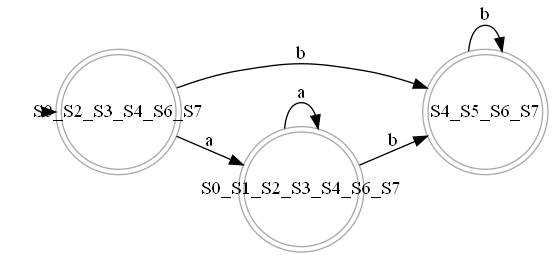

./out_imgs/Minimized_DFA_FSM.html


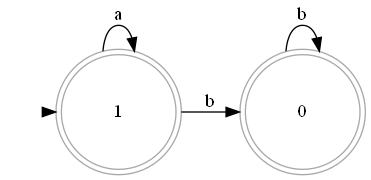

In [24]:
def print_states(fsm):
    for k, v in fsm.states.items():
        print(f'{k} -> {v.is_terminating_state} -> {v.transitions}')

if __name__ == "__main__":
    state_machine = AutomataMachine().init_from_file('output.json')
    # display(Markdown(f"# asdas"))
    display(state_machine.draw())
    dfa_gen = dfa_generator('output.json')
    # aa = dfa.get_closure(dfa.nfa_sm.get_state('S2'))
    new_dfa = dfa_gen.convert_to_dfa()
    print_states(new_dfa)
    display(new_dfa.draw())
    new_dfa.save_to_json('dfa.json')
    minimizer = DFA_Minimizer(new_dfa)
    minimizer.minimize()
    minized_dfa = minimizer.reconstruct_dfa()
    display(minized_dfa.draw())

